<a href="https://colab.research.google.com/github/MWFK/TensorFlow-Certificate-study-materials/blob/main/08.%20Cats_vs_Dogs_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import and configure InceptionV3

Pro tip: You just want to load the skeleton of the Inception network without its built in default weights. 

You also don't want the fully connected layer at the top (start) of the network and want to get straight to the convolutional layers. 

You then load the weights that have already been trained by someone else into this skeleton.

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# https://keras.io/api/applications/inceptionv3/
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-05-02 14:18:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   113MB/s    in 0.7s    

2021-05-02 14:18:15 (113 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                  

# Build custom Model for Prediction 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output) # the last layer of the InceptionV3 will be the input of our model

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

'''
from keras.applications.vgg16 import VGG16

[1] Pretrained model
base = VGG16(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
             include_top=False,
             input_shape=(150,225,3))

[2] Data that will be fed to the Pretrained model
in = Input(shape=(150,225,3))

[3] Output of the Data processed by the Pretrained model  
base_out = base(in)

[4] Feed the processed Data by the Pretrained model to the a Custom model
out = Flatten()(base_out)
out = Dense(256, activation='relu')
out = Dense(1, activation='sigmoid')

[5] Feed the pretrained model using our Data to our custom layers, and get our tailored model.
model = Model(in, out)

model.summary()
'''

"\nfrom keras.applications.vgg16 import VGG16\n\n[1] Pretrained model\nbase = VGG16(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',\n             include_top=False,\n             input_shape=(150,225,3))\n\n[2] Data that will be fed to the Pretrained model\nin = Input(shape=(150,225,3))\n\n[3] Output of the Data processed by the Pretrained model  \nbase_out = base(in)\n\n[4] Feed the processed Data by the Pretrained model to the a Custom model\nout = Flatten()(base_out)\nout = Dense(256, activation='relu')\nout = Dense(1, activation='sigmoid')\n\n[5] Feed the pretrained model using our Data to our custom layers, and get our tailored model.\nmodel = Model(in, out)\n\nmodel.summary()\n"

# Build Final Model using configured InceptionV3 and a custom Prediction model

In [ ]:
# model = Model(in, out)
model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )



# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-05-02 14:18:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   106MB/s    in 0.6s    

2021-05-02 14:18:18 (106 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 57s - loss: 0.3500 - accuracy: 0.8590 - val_loss: 0.1122 - val_accuracy: 0.9520
Epoch 2/20
100/100 - 22s - loss: 0.2334 - accuracy: 0.9130 - val_loss: 0.0960 - val_accuracy: 0.9600
Epoch 3/20
100/100 - 23s - loss: 0.1883 - accuracy: 0.9300 - val_loss: 0.1032 - val_accuracy: 0.9660
Epoch 4/20
100/100 - 22s - loss: 0.1934 - accuracy: 0.9320 - val_loss: 0.1674 - val_accuracy: 0.9470
Epoch 5/20
100/100 - 22s - loss: 0.1916 - accuracy: 0.9335 - val_loss: 0.1268 - val_accuracy: 0.9580
Epoch 6/20
100/100 - 22s - loss: 0.2053 - accuracy: 0.9245 - val_loss: 0.0788 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 22s - loss: 0.1651 - accuracy: 0.9365 - val_loss: 0.0957 - val_accuracy: 0.9690
Epoch 8/20
100/100 - 22s - loss: 0.1987 - accuracy: 0.9335 - val_loss: 0.1242 - val_accuracy: 0.9620
Epoch 9/20
100/100 - 22s - loss: 0.1649 - accuracy: 0.9435 - val_loss: 0.0963 - val_accuracy: 0.9680
Epoch 10/20
100/100 - 23s - loss: 0.1498 - accuracy: 0.9485 - val_loss: 0.1027 - val_accura

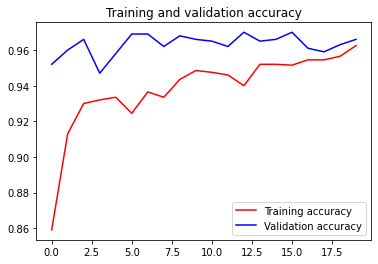

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()